# Exploring Feature Importance and Feature Interaction

This notebook explores ideas around Feature Importance and Feature Interaction by generating a synthetic data set with fetures of different feature importance and interactivity. Its purpose is to validate using methods of feature importance and to explore methods of discovering features which have strong interaction with other features

In [5]:
%matplotlib inline
# from fastai.imports import *
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math

First create features from different random distributions. Features were designed to be roughly normalised with a range of [-1, 1]. Different distributions were used to see if this had an effect on feature importance.

In [10]:
n_samples = 10000

In [11]:
x1 = np.random.normal(0, 0.4, n_samples)
x2 = np.random.normal(0.02, 0.37, n_samples)
x3 = np.random.normal(0, 0.2, n_samples)
x4 = np.random.normal(0, 0.3, n_samples)
x5 = np.random.normal(-1, 0.5, n_samples)
x6 = np.random.lognormal(-1, 0.3, n_samples)
x7 = np.random.lognormal(0, 0.4, n_samples) - 1.5
x8 = np.random.uniform(-1, 1, n_samples)
x9 = np.random.uniform(-1, 1, n_samples)
x10 = np.random.uniform(-1, 1, n_samples)

Example of a Normally distributed feature

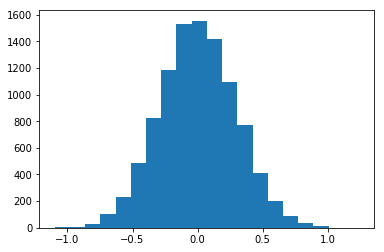

In [13]:
plt.hist(x4, bins=20)
plt.show()

In [ ]:
Example of a log normal distributed feature

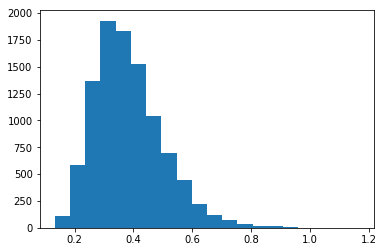

In [15]:
plt.hist(x6, bins=20)
plt.show()

uniform dist

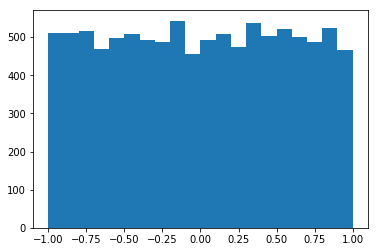

In [16]:
plt.hist(x10, bins=20)
plt.show()

Now we create our independent variable 'y'. 

In [18]:
# Start with our strongest feature we want to see if we can find later x2-x1
y = 10*(x2-x1)

# give x1 a small amount of influence also on prediction
y -= x1

# give x2 a moderate amount of influence also on prediction
y += 3*x2

# give x3 the largest amount of singular prediction from any 1 variable
y += 6*x3

# give x4 the least (but not no) amount of prediction
y += 0.2*x4

# give x5 a small amount of prediction
y -= 2*x5

# give varying amounts for all other variables
y += 4.5*x6
y -= 3*x7
y += 0.7*x8
y -= 2*x9
# x10 has no effect on y - redundant code below
y += 0*x10 

# Add one more weak correlation interaction
y -= 5*(x4-x9)

# Add a bias
y += 32.5

# Add some random noise
y += np.random.normal(0, 1, y.shape)

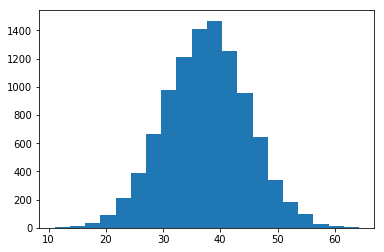

In [19]:
plt.hist(y, bins=20)
plt.show()

In [20]:
y.min(), y.max()

(11.071337246179551, 64.236042068964792)

stack all of our independent variables x1, x2, ..., x10 into a pd data frame. So that we can input them into our model

In [21]:
x = {'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5,
     'x6': x6, 'x7': x7, 'x8': x8, 'x9': x9, 'x10': x10}

x = pd.DataFrame(x)

In [22]:
x.head()

,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9
0,-0.315701,-0.739690,0.178217,0.076200,-0.308587,0.099228,0.429301,-0.505149,-0.949489,-0.458234
1,0.187499,0.502676,0.178455,-0.246496,0.187389,-0.146690,0.381430,0.301302,-0.732399,-0.693020
2,-0.121356,0.617930,0.241300,0.279202,0.028579,-0.555617,0.290578,-0.794813,0.199009,-0.895047
3,-0.038622,-0.520185,0.090391,0.045961,-0.273389,-0.758547,0.353655,-0.452470,-0.201050,-0.018440
4,0.562953,-0.245100,-0.116438,-0.262834,0.197839,-1.543603,0.603919,-0.368395,-0.993657,0.851486


In [23]:
x.shape

(10000, 10)

Split dataset and labels into train, validate and test

In [28]:
x_trn, x_val, x_test = x.iloc[:8000, :], x.iloc[8000:9000, :], x.iloc[9000:, :]
y_trn, y_val, y_test = y[:8000], y[8000:9000], y[9000:]

In [29]:
x_trn.shape, x_val.shape, x_test.shape

((8000, 10), (1000, 10), (1000, 10))

In [30]:
y_trn.shape, y_val.shape, y_test.shape

((8000,), (1000,), (1000,))

In [31]:
m = RandomForestRegressor(n_estimators=50).fit(x_trn, y_trn)

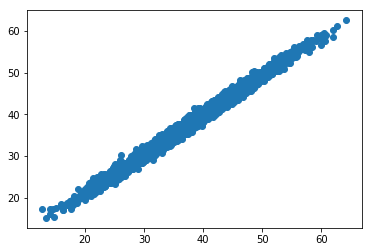

In [32]:
plt.scatter(y_trn, m.predict(x_trn))
plt.show()

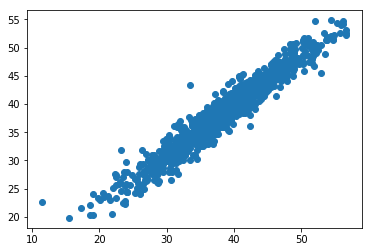

In [33]:
plt.scatter(y_val, m.predict(x_val))

In [34]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, pass_back=False):
    res = [rmse(m.predict(x_trn), y_trn), rmse(m.predict(x_val), y_val),
                m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    if pass_back:
        return res

In [35]:
scores = print_score(m)

[0.7383850568938075, 1.8950727719029592, 0.98959534488071788, 0.92778527461429938]


In [ ]:
# Too much noise in the model when plotted on the validation set

In [150]:
# set hyper parameter search space
hps = {
    'n_ests': [10, 20, 50, 80, 100, 150, 300, 500],
    'msls': [2],
    'max_features': [0.5]
}

# create new dataframe to store results
hp_cols = ['n_estimators', 'min_samples_leaf', 'max_features',
           'rmse_train', 'rmse_valid', 'r-squared_train',
           'r-squared_valid', 'r-squared_oob']
hp_results = pd.DataFrame(columns=hp_cols)

# grid search different hyper parameters
for n_est in hps['n_ests']:
    for msl in hps['msls']:
        for max_feat in hps['max_features']:
            t0 = time.time()
            print('\ntraining a model...')
            m = RandomForestRegressor(n_estimators=n_est, min_samples_leaf=msl, 
                          max_features=max_feat, n_jobs=-1, oob_score=True)
            m.fit(x_trn, y_trn)
            t1 = time.time()
            scores = print_score(m, pass_back=True)
            row = {}
            row['n_estimators'] = n_est
            row['min_samples_leaf'] = msl
            row['max_features'] = max_feat
            row['rmse_train'] = scores[0]
            row['rmse_valid'] = scores[1]
            row['r-squared_train'] = scores[2]
            row['r-squared_valid'] = scores[3]
            row['r-squared_oob'] = scores[4]
            row['time'] = round(t1-t0, 2)
            print(f'\nJust fininised training this combo:\n{row}')
            hp_results = hp_results.append(row, ignore_index=True)
            hp_results.to_csv('synthetic_search.csv', index=False)


training a model...


/Users/robertdumbleton/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1.3956400393994124, 2.8686921956673945, 0.9630627887120348, 0.8295242378975726, 0.7373078374130321]

Just fininised training this combo:
{'n_estimators': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'rmse_train': 1.3956400393994124, 'rmse_valid': 2.8686921956673945, 'r-squared_train': 0.9630627887120348, 'r-squared_valid': 0.8295242378975726, 'r-squared_oob': 0.7373078374130321, 'time': 0.11}

training a model...
[1.2844808057723576, 2.851375829627511, 0.9687123819886242, 0.8315761213445654, 0.8470945055210524]

Just fininised training this combo:
{'n_estimators': 20, 'min_samples_leaf': 2, 'max_features': 0.5, 'rmse_train': 1.2844808057723576, 'rmse_valid': 2.851375829627511, 'r-squared_train': 0.9687123819886242, 'r-squared_valid': 0.8315761213445654, 'r-squared_oob': 0.8470945055210524, 'time': 0.12}

training a model...
[1.1736747400204857, 2.744330829642334, 0.9738776178614328, 0.8439845292822356, 0.8699430036428457]

Just fininised training this combo:
{'n_estimators': 50, 'm

In [151]:
hp_results = hp_results.sort_values(['rmse_valid'], ascending=True)
hp_results.head(10)

,n_estimators,min_samples_leaf,max_features,rmse_train,rmse_valid,r-squared_train,r-squared_valid,r-squared_oob,time
3,80.0,2.0,0.5,1.129323,2.651079,0.975815,0.854407,0.882414,0.15
5,150.0,2.0,0.5,1.129835,2.687611,0.975793,0.850367,0.882879,0.30
7,500.0,2.0,0.5,1.130809,2.691964,0.975751,0.849882,0.883996,0.78
6,300.0,2.0,0.5,1.135591,2.721773,0.975545,0.846539,0.882943,0.47
2,50.0,2.0,0.5,1.173675,2.744331,0.973878,0.843985,0.869943,0.13
4,100.0,2.0,0.5,1.159534,2.762536,0.974503,0.841908,0.877203,0.27
1,20.0,2.0,0.5,1.284481,2.851376,0.968712,0.831576,0.847095,0.12
0,10.0,2.0,0.5,1.395640,2.868692,0.963063,0.829524,0.737308,0.11


In [143]:
hp_results = hp_results.sort_values(['rmse_valid'], ascending=True)
hp_results.head(10)

,n_estimators,min_samples_leaf,max_features,auroc_train,auroc_valid,r-squared_train,r-squared_valid,r-squared_oob,rmse_train,rmse_valid,time
3,35.0,8.0,0.6,NaN,NaN,0.916548,0.807108,0.845753,2.097776,3.051476,0.12
27,140.0,8.0,0.6,NaN,NaN,0.922056,0.806922,0.856173,2.027374,3.052944,0.18
15,70.0,8.0,0.6,NaN,NaN,0.918104,0.806095,0.851699,2.078135,3.059476,0.14
26,140.0,8.0,0.4,NaN,NaN,0.906908,0.806093,0.838034,2.215636,3.059492,0.18
14,70.0,8.0,0.4,NaN,NaN,0.907048,0.800705,0.835556,2.213965,3.101707,0.15
2,35.0,8.0,0.4,NaN,NaN,0.904053,0.781322,0.827398,2.249352,3.249041,0.13
19,70.0,16.0,0.6,NaN,NaN,0.867825,0.769531,0.810196,2.640077,3.335481,0.15
31,140.0,16.0,0.6,NaN,NaN,0.868865,0.762685,0.819105,2.629663,3.384661,0.18
7,35.0,16.0,0.6,NaN,NaN,0.869331,0.762557,0.811657,2.624992,3.385575,0.12
30,140.0,16.0,0.4,NaN,NaN,0.851966,0.762018,0.797225,2.793968,3.389414,0.17


In [ ]:
2, 5, and 80 look like decent params

In [193]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=2, max_features=0.5)
m.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

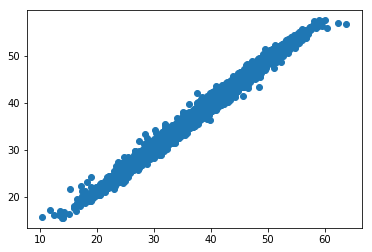

In [194]:
plt.scatter(y_trn, m.predict(x_trn))

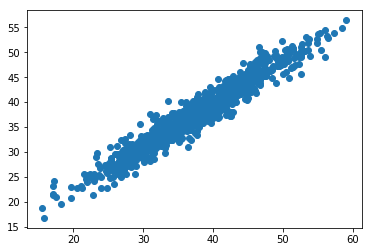

In [195]:
plt.scatter(y_val, m.predict(x_val))

In [196]:
scores = print_score(m)

[0.858913795008536, 1.9795882074055693, 0.9859333990316793, 0.9304046452014891]


In [ ]:
# Now - Feature importance

In [191]:
df_importance = pd.DataFrame()
for col in x_val.columns:
    x_shuffle = x_val.copy()
    shuffled_column = x_shuffle[col].values
    np.random.shuffle(shuffled_column)
    x_shuffle[col] = shuffled_column
    rmse_score = rmse(y_val, m.predict(x_shuffle))
    row = {}
    row['col'] = col
    row['score'] = rmse_score
    df_importance = df_importance.append(row, ignore_index=True)

df_importance = df_importance.sort_values(by='score')

In [192]:
top_ten_fi_vars = df_importance.reset_index(drop=True).iloc[:10, 0].values

full_score = 0.8468986747170683
df_importance['error_diff'] = full_score - df_importance['score']

error_diffs = {row['col']: row['error_diff'] for i, row in df_importance.iterrows()}

df_importance = df_importance.sort_values(by='error_diff', ascending=True)
df_importance.head(10)

,col,score,error_diff
1,x2,6.821676,-5.974777
0,x1,6.794578,-5.947679
8,x9,2.816958,-1.970059
3,x4,2.572822,-1.725924
6,x7,2.501193,-1.654295
2,x3,2.297550,-1.450651
4,x5,2.169139,-1.322241
5,x6,2.027261,-1.180363
7,x8,2.009967,-1.163068
9,x10,1.965821,-1.118922
